In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()   # select kaggle.json from your computer

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"nisanthnoel","key":"853a13f30368ba5603827131688dad85"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d abhinand05/crop-production-in-india

Dataset URL: https://www.kaggle.com/datasets/abhinand05/crop-production-in-india
License(s): other
crop-production-in-india.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip '*.zip'

import pandas as pd

# Adjust file name as needed (check after unzip)
df = pd.read_csv('crop_production.csv')
df.head()

Archive:  crop-production-in-india.zip
replace crop_production.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: crop_production.csv     


,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Arecanut,1254.0,2000.0
1,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Other Kharif pulses,2.0,1.0
2,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Rice,102.0,321.0
3,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Banana,176.0,641.0
4,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Cashewnut,720.0,165.0


In [ ]:
print(df.info())
print(df.describe())
print(df.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246091 entries, 0 to 246090
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   State_Name     246091 non-null  object 
 1   District_Name  246091 non-null  object 
 2   Crop_Year      246091 non-null  int64  
 3   Season         246091 non-null  object 
 4   Crop           246091 non-null  object 
 5   Area           246091 non-null  float64
 6   Production     242361 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 13.1+ MB
None
           Crop_Year          Area    Production
count  246091.000000  2.460910e+05  2.423610e+05
mean     2005.643018  1.200282e+04  5.825034e+05
std         4.952164  5.052340e+04  1.706581e+07
min      1997.000000  4.000000e-02  0.000000e+00
25%      2002.000000  8.000000e+01  8.800000e+01
50%      2006.000000  5.820000e+02  7.290000e+02
75%      2010.000000  4.392000e+03  7.023000e+03
max      2015.000000  8.5

In [ ]:
import numpy as np

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)

Numeric columns: ['Crop_Year', 'Area', 'Production']


In [ ]:
def minmax_scale_manual(df, cols=None, feature_range=(0,1)):
    a, b = feature_range
    scaled_df = df.copy()
    if cols is None:
        cols = scaled_df.select_dtypes(include=[np.number]).columns.tolist()
    for c in cols:
        col = scaled_df[c].astype(float)
        minv, maxv = col.min(), col.max()
        if minv == maxv:
            scaled_df[c] = a  # constant column
        else:
            scaled_df[c] = ((col - minv) / (maxv - minv)) * (b - a) + a
    return scaled_df

scaled_df = minmax_scale_manual(df, numeric_cols)
scaled_df[numeric_cols].describe().loc[['min', 'max']]

,Crop_Year,Area,Production
min,0.0,0.0,0.0
max,1.0,1.0,1.0


In [ ]:
# Group-wise Min–Max scaling by 'State_Name'
def groupwise_minmax_scale(df, group_col, cols=None, feature_range=(0,1)):
    a, b = feature_range
    scaled_df = df.copy()
    if cols is None:
        cols = scaled_df.select_dtypes(include=[np.number]).columns.tolist()

    # Apply scaling within each group
    for c in cols:
        scaled_df[c] = scaled_df.groupby(group_col)[c].transform(
            lambda x: ((x - x.min()) / (x.max() - x.min())) * (b - a) + a if x.max() != x.min() else a
        )
    return scaled_df

# Example: scale all numeric columns within each State_Name group
scaled_state_df = groupwise_minmax_scale(df, group_col='State_Name', cols=numeric_cols)
scaled_state_df.head()

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,Andaman and Nicobar Islands,NICOBARS,0.0,Kharif,Arecanut,0.068162,2.804909e-05
1,Andaman and Nicobar Islands,NICOBARS,0.0,Kharif,Other Kharif pulses,0.000098,1.262272e-08
2,Andaman and Nicobar Islands,NICOBARS,0.0,Kharif,Rice,0.005534,4.500701e-06
3,Andaman and Nicobar Islands,NICOBARS,0.0,Whole Year,Banana,0.009557,8.988780e-06
4,Andaman and Nicobar Islands,NICOBARS,0.0,Whole Year,Cashewnut,0.039131,2.312763e-06


In [ ]:
# Separate categorical & numeric columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

Categorical columns: ['State_Name', 'District_Name', 'Season', 'Crop']
Numeric columns: ['Crop_Year', 'Area', 'Production']


In [ ]:

from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le  # store encoder for inverse_transform later if needed

print("✅ Label encoding complete")
df_encoded.head()

✅ Label encoding complete


,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,0,427,2000,1,2,1254.0,2000.0
1,0,427,2000,1,74,2.0,1.0
2,0,427,2000,1,95,102.0,321.0
3,0,427,2000,4,7,176.0,641.0
4,0,427,2000,4,22,720.0,165.0


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = df_encoded.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

print("✅ Standard scaling complete")
df_scaled[numeric_cols].describe().loc[['mean', 'std']]

✅ Standard scaling complete


,Crop_Year,Area,Production
mean,1.510321e-14,-1.778587e-17,1.451951e-17
std,1.000002e+00,1.000002e+00,1.000002e+00


In [ ]:
minmax_df = minmax_scale_manual(df, numeric_cols)
minmax_df.to_csv("dataset_minmax.csv", index=False)

In [ ]:
state_minmax_df = groupwise_minmax_scale(df, group_col='State_Name', cols=numeric_cols)
state_minmax_df.to_csv("dataset_state_minmax.csv", index=False)

In [ ]:
df_label_encoded = df.copy()
for col in categorical_cols:
    le = LabelEncoder()
    df_label_encoded[col] = le.fit_transform(df_label_encoded[col].astype(str))
df_label_encoded.to_csv("dataset_label_encoded.csv", index=False)

In [ ]:
scaler = StandardScaler()
df_standard_scaled = df_label_encoded.copy()
df_standard_scaled[numeric_cols] = scaler.fit_transform(df_standard_scaled[numeric_cols])
df_standard_scaled.to_csv("dataset_standard_scaled.csv", index=False)

In [ ]:
df_mm_le = minmax_scale_manual(df, numeric_cols)
for col in categorical_cols:
    le = LabelEncoder()
    df_mm_le[col] = le.fit_transform(df_mm_le[col].astype(str))
df_mm_le.to_csv("dataset_minmax_labelencoded.csv", index=False)

In [ ]:
df_std_le = df_label_encoded.copy()
df_std_le[numeric_cols] = scaler.fit_transform(df_std_le[numeric_cols])
df_std_le.to_csv("dataset_standard_labelencoded.csv", index=False)

In [ ]:
datasets = [
    "dataset_minmax.csv",
    "dataset_state_minmax.csv",
    "dataset_label_encoded.csv",
    "dataset_standard_scaled.csv",
    "dataset_minmax_labelencoded.csv",
    "dataset_standard_labelencoded.csv"
]

for d in datasets:
    print("Saved:", d)

Saved: dataset_minmax.csv
Saved: dataset_state_minmax.csv
Saved: dataset_label_encoded.csv
Saved: dataset_standard_scaled.csv
Saved: dataset_minmax_labelencoded.csv
Saved: dataset_standard_labelencoded.csv


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df_model = pd.read_csv("dataset_standard_labelencoded.csv")
df_model = df_model.dropna(subset=['Production'])
df_model = df_model.fillna(0)

target_col = 'Production'
X = df_model.drop(columns=[target_col])
y = df_model[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Linear Regression → MAE: 0.09253317485001462 RMSE: 1.1716074074984064 R²: 0.006368027228821127


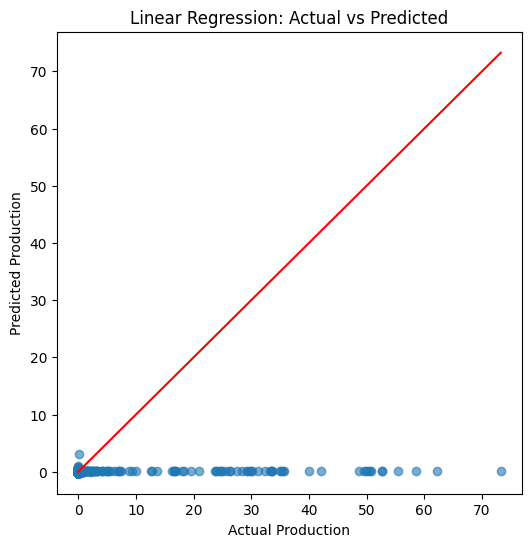

In [ ]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression → MAE:", mae_lr, "RMSE:", rmse_lr, "R²:", r2_lr)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.xlabel("Actual Production")
plt.ylabel("Predicted Production")
plt.title("Linear Regression: Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.show()


Random Forest → MAE: 0.008015400872138626 RMSE: 0.30730956416107447 R²: 0.9316381993821385


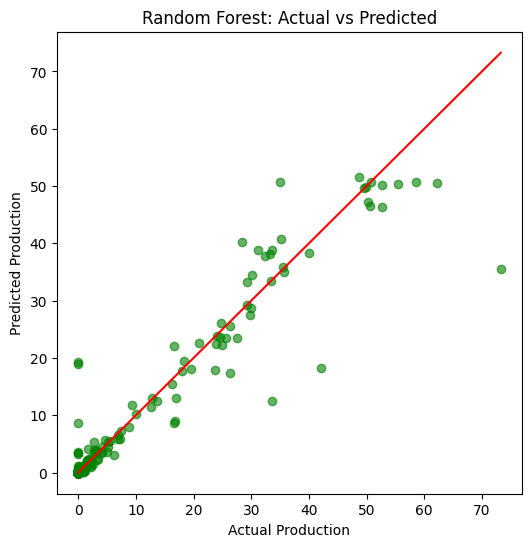

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest → MAE:", mae_rf, "RMSE:", rmse_rf, "R²:", r2_rf)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='green')
plt.xlabel("Actual Production")
plt.ylabel("Predicted Production")
plt.title("Random Forest: Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.show()